# Assignment 1: Color Spaces, Morphological Operators

## Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in in /images.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



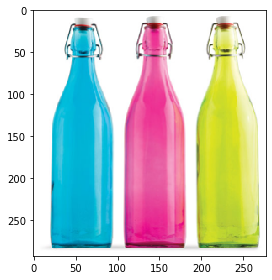

In [6]:
%matplotlib inline 
from skimage import io, data, color
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = io.imread('images/bottles.png')
io.imshow(image)

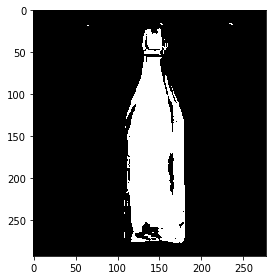

In [14]:
ranges = [(220, 255), (30, 150), (120, 200)]

red_range   = np.logical_and(ranges[0][0] <= image[:,:,0], image[:,:,0] <= ranges[0][1])
green_range = np.logical_and(ranges[1][0] <= image[:,:,1], image[:,:,1] <= ranges[1][1])
blue_range  = np.logical_and(ranges[2][0] <= image[:,:,2], image[:,:,2] <= ranges[2][1])
valid_range = np.logical_and(red_range, green_range, blue_range)

binary = np.copy(image)
binary[valid_range] = 255
binary[np.logical_not(valid_range)] = 0

io.imshow(binary)

## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

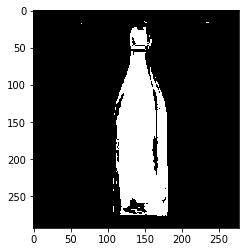

In [15]:
# binary image with only dimension/color-channel
binary_1d = binary[:,:,0]

# normalized: each pixel is 0 or 1
normalized_binary = binary_1d / 255

plt.imshow(normalized_binary, cmap='gray')

In [16]:
window = np.array([
    [0.0, 1.0, 0.0],
    [1.0, 1.0, 1.0],
    [0.0, 1.0, 0.0]
])
window.setflags(write=False)
windowsum = np.sum(window)


# TODO: padding (crashes if border any pixel has noise)

def erosion(im, w=window, wsum=windowsum):
    image_width = im.shape[0]
    image_height = im.shape[1]
    res = np.copy(im)
    
    for i in range(image_width):
        for j in range(image_height):
            if(im[i,j] != 0.0):
                temp_im = np.array([[im[i-1,j-1], im[i,j-1], im[i+1,j-1]],
                                    [im[i-1,j],   im[i,j],   im[i+1,j]],
                                    [im[i-1,j+1], im[i,j+1], im[i+1,j+1]]])
                checksum = np.sum(w*temp_im)
                if(checksum != wsum):
                    res[i,j] = 0.0
    return res


def dilation(im, w=window, wsum=windowsum):
    image_width = im.shape[0]
    image_height = im.shape[1]
    res = np.copy(im)
    
    for i in range(image_width-2):
        for j in range(image_height-2):
            temp_im = np.array([[im[i,j],   im[i+1,j],   im[i+2,j]],
                                [im[i,j+1], im[i+1,j+1], im[i+2,j+1]],
                                [im[i,j+2], im[i+1,j+2], im[i+2,j+2]]])
            
            checksum = np.sum(w*temp_im)
            if(checksum != 0.0):
                res[i+1,j+1] = 1.0
    return res

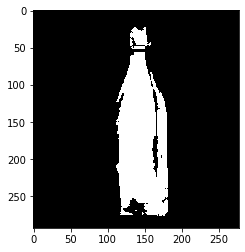

In [10]:
denoised = dilation(erosion(normalized_binary))
plt.imshow(denoised, cmap='gray')

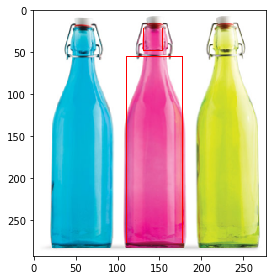

In [22]:
from collections import defaultdict
from dataclasses import dataclass
import sys

from skimage.draw import rectangle_perimeter


# np.set_printoptions(
#     threshold=sys.maxsize,
#     linewidth=900,
# )


@dataclass
class BoundingBox:
    top: int = None
    left: int = None
    bottom: int = None
    right: int = None
    
    def update(self, row, col):
        """Works only if pixels are iterated top-left to bottom-right."""
        if not self.top and not self.left:
            self.top = row
            self.left = col
        elif col < self.left:
            self.left = col
        self.bottom = row
        self.right = col

    @property
    def center(self):
        return np.mean(( (self.top, self.bottom), (self.left, self.right) ), axis=1)

    @property
    def size(self):
        return (self.bottom - self.top) * (self.bottom - self.top)


def two_pass_alogrithm(image, bbox_threshold=(10, 10)):
    # Combine color channels to single boolean values, and then map to {0,1}.
#     image = np.logical_or.reduce(image, axis=2).astype(np.uint8)
    label_counter = 1
    equivalence_classes = []

    def get_eqclass(label):
        return next(s for s in equivalence_classes if label in s)
    
    def label_pixel(row, col):
        # background pixel => nothing of interest => nothing to do
        if not image[row, col]:
            return

        # We treat the background (zero values) as np.inf for more convenient calculation.
        left = np.inf
        top = np.inf
        if col > 0:
            left = int(image[row, col - 1]) or np.inf
        if row > 0:
            top = int(image[row - 1, col]) or np.inf

        # new label
        if left == np.inf and top == np.inf:
            nonlocal label_counter
            label = label_counter
            label_counter += 1
            equivalence_classes.append({label})
        else:
            low, high = (top, left) if top < left else (left, top)
            label = low
            # Connect 2 areas => merge according equivalence classes.
            if low != np.inf and high != np.inf and low != high:
                eqclass_low = get_eqclass(low)
                eqclass_high = get_eqclass(high)
                # Different labels may point to the same equivalence class
                if eqclass_low != eqclass_high:
                    equivalence_classes.remove(eqclass_low)
                    equivalence_classes.remove(eqclass_high)
                    equivalence_classes.append(eqclass_high | eqclass_low)

        image[row, col] = label

    rows, cols = image.shape[0:2]
    for row in range(rows):
        for col in range(cols):
            label_pixel(row, col)
    
    bboxes = defaultdict(BoundingBox)
    for row in range(rows):
        for col in range(cols):
            label = image[row, col]
            if label:
                corrected_label = min(get_eqclass(label))
                image[row, col] = corrected_label
                bboxes[corrected_label].update(row, col)
    
    bboxes = tuple(
        box
        for box in bboxes.values()
        if (
            box.bottom - box.top >= bbox_threshold[0]
            and box.right - box.left >= bbox_threshold[1]
        )
    )
    
    return bboxes, image


bboxes, _ = two_pass_alogrithm(denoised)
original_with_bboxes = np.copy(image)
bbox_color = np.array([255, 0, 0])
for bbox in bboxes:
    rr, cc = rectangle_perimeter(start=(bbox.top, bbox.left), end=(bbox.bottom, bbox.right))
    original_with_bboxes[rr, cc] = bbox_color

io.imshow(original_with_bboxes)

## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

In [21]:
from multiprocessing import Pool

from numpy import linalg
from skimage.draw import circle


images = io.imread_collection('images/taco/*')[:20]
# print(len(images))

last_frame = images[-1]

ranges = [(205, 255), (79, 164), (0, 97)]


def get_bboxes(image, threshold=(1, 1)):
    print('.', end='')
    red_range   = np.logical_and(ranges[0][0] <= image[:,:,0], image[:,:,0] <= ranges[0][1])
    green_range = np.logical_and(ranges[1][0] <= image[:,:,1], image[:,:,1] <= ranges[1][1])
    blue_range  = np.logical_and(ranges[2][0] <= image[:,:,2], image[:,:,2] <= ranges[2][1])
    valid_range = np.logical_and(red_range, green_range, blue_range)
    
    binary = np.copy(image)
    binary[valid_range] = 255
    binary[np.logical_not(valid_range)] = 0
    normalized_binary = binary[:,:,0] / 255
    denoised = dilation(erosion(normalized_binary))
    bboxes, _ = two_pass_alogrithm(denoised, bbox_threshold=threshold)
    return bboxes


pool = Pool()
bboxes_per_image = pool.map(get_bboxes, images)

# circle_colors = [[0, 0, 255], [255, 0, 0], [255, 255, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
# print(bboxes_per_image)
last_frame_with_history = np.copy(last_frame)

prev_center = None
for i, bboxes in enumerate(bboxes_per_image):
    if not bboxes:
        print(f'no bounding boxes returned by 2pass for {i}. image...')
        continue

    # Select bounding box closest to the previously selected one.
    if prev_center is not None:
        selected_bbox = sorted(
            bboxes,
            # https://stackoverflow.com/a/1401828/6928824
            key=lambda box: linalg.norm(box.center - prev_center),
            reverse=False,
        )[0]
    # Select largest bounding box initially.
    else:
        selected_bbox = sorted(
            bboxes,
            key=lambda box: box.size,
            reverse=True,
        )[0]
    
    center = selected_bbox.center
    # print(sorted_bboxes)
    rr, cc = circle(*center, radius=5, shape=last_frame.shape)
    last_frame_with_history[rr, cc] = [0, 0, 255]
    
    prev_center = center
    
#     for i, box in enumerate(sorted_bboxes):
#         rr, cc = circle(*box.center, radius=(5 / (i + 1)), shape=last_frame.shape)
#         last_frame_with_history[rr, cc] = circle_colors[i]

io.imshow(last_frame_with_history)

[(BoundingBox(top=127, left=375, bottom=171, right=410), BoundingBox(top=127, left=426, bottom=130, right=428), BoundingBox(top=142, left=426, bottom=144, right=428), BoundingBox(top=142, left=432, bottom=145, right=433), BoundingBox(top=144, left=436, bottom=147, right=439), BoundingBox(top=149, left=388, bottom=151, right=390), BoundingBox(top=153, left=430, bottom=157, right=432), BoundingBox(top=156, left=438, bottom=159, right=439), BoundingBox(top=161, left=366, bottom=167, right=372), BoundingBox(top=164, left=433, bottom=173, right=441), BoundingBox(top=168, left=75, bottom=171, right=79), BoundingBox(top=174, left=1, bottom=343, right=25), BoundingBox(top=176, left=80, bottom=180, right=84), BoundingBox(top=177, left=443, bottom=182, right=447), BoundingBox(top=183, left=447, bottom=188, right=450), BoundingBox(top=190, left=70, bottom=197, right=75), BoundingBox(top=191, left=448, bottom=203, right=449), BoundingBox(top=204, left=389, bottom=225, right=436), BoundingBox(top=2

IndexError: list index out of range